# 10. Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get you familiar with working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin. 

Welcome to Milestone Project 3, BitPredict 💰📈!

> 🔑 **Note:** ⚠️ This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

## What is a time series problem?

Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

![example time series problems](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-example-time-series-problems.png)

| Problem Type | Examples | Output |
| ----- | ----- | ----- |
| **Classification** | Anomaly detection, time series identification (where did this time series come from?) | Discrete (a label) |
| **Forecasting** | Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements | Continuous (a number) |

In both cases above, a supervised learning approach is often used. Meaning, you'd have some example data and a label assosciated with that data.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

Can you guess what kind of problem BitPredict 💰📈 is?

## What we're going to cover

Are you ready?

We've got a lot to go through. 

* Get time series data (the historical price of Bitcoin)
  * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
  * Creating training and test sets (the wrong way)
  * Creating training and test sets (the right way)
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
  * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
  * Dense (fully-connected) networks
  * Sequence models (LSTM and 1D CNN)
  * Ensembling (combining multiple models together)
  * Multivariate models
  * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem) 

## How you can use this notebook
You can read through the descriptions and the code (it should all run), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

> 📖 **Resource:** Get all of the materials you need for this notebook on the [course GitHub](https://github.com/mrdbourke/tensorflow-deep-learning).



## Check for GPU

In order for our deep learning models to run as fast as possible, we'll need access to a GPU.

In Google Colab, you can set this up by going to Runtime -> Change runtime type -> Hardware accelerator -> GPU.

After selecting GPU, you may have to restart the runtime.

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-6ed68d2f-bb36-07fa-b6bc-33d43339c6bf)


## Get data

To build a time series forecasting model, the first thing we're going to need is data.

And since we're trying to predict the price of Bitcoin, we'll need Bitcoin data.

Specifically, we're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

Why these dates?

Because 01 October 2013 is when our data source ([Coindesk](https://www.coindesk.com/price/bitcoin)) started recording the price of Bitcoin and 18 May 2021 is when this notebook was created.

If you're going through this notebook at a later date, you'll be able to use what you learn to predict on later dates of Bitcoin, you'll just have to adjust the data source.

> 📖 **Resource:** To get the Bitcoin historical data, I went to the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), clicked on "all" and then clicked on "Export data" and selected "CSV". 

You can find the data we're going to use on [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).



In [ ]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2022-01-06 17:38:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-01-06 17:38:43 (7.47 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas
Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in **CSV (comma separated values)** format (a very common data format for time series), we'll use the pandas [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name our of the date column ("Date").

In [ ]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


Looking good! Let's get some more info.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

You can also see there isn't many samples.

In [ ]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

For example, collecting one sample at different time frames results in:

| 1 sample per timeframe | Number of samples per year |
| ----- | ----- |
| Second | 31,536,000 |
| Hour | 8,760 |
| Day | 365 |
| Week | 52 |
| Month | 12 |

> 🔑 **Note:** The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months). For more on different time series patterns, see [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html).

![different types of time series patterns](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-types-of-time-series-patterns.png)
*Example of different kinds of patterns you'll see in time series data. Notice the bottom right time series (Google stock price changes) has little to no patterns, making it difficult to predict. See [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html) for full graphic.*

Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [ ]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Much better!

But that's only five days worth of Bitcoin prices, let's plot everything we've got.

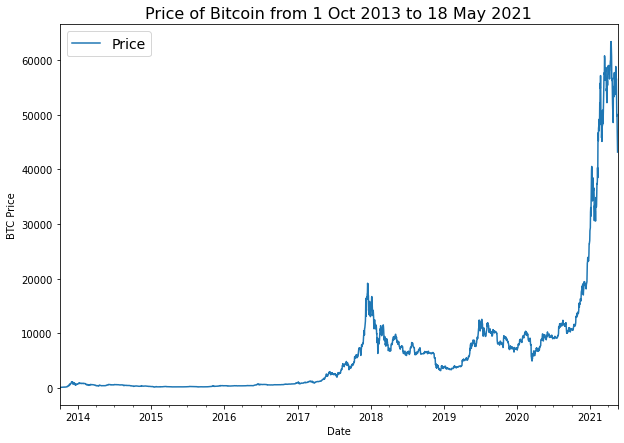

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

Woah, looks like it would've been a good idea to buy Bitcoin back in 2014.

### Importing time series data with Python's CSV module

If your time series data comes in CSV form you don't necessarily have to use pandas.

You can use Python's [in-built `csv` module](https://docs.python.org/3/library/csv.html). And if you're working with dates, you might also want to use Python's [`datetime`](https://docs.python.org/3/library/datetime.html).

Let's see how we can replicate the plot we created before except this time using Python's `csv` and `datetime` modules.

> 📖 **Resource:** For a great guide on using Python's `csv` module, check out Real Python's tutorial on [Reading and Writing CSV files in Python](https://realpython.com/python-csv/).

In [ ]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Beautiful! Now, let's see how things look.

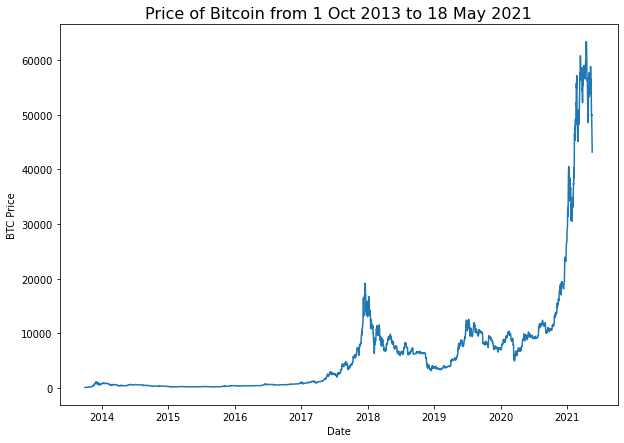

In [ ]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

Ho ho! Would you look at that! Just like the pandas plot. And because we formatted the `timesteps` to be `datetime` objects, `matplotlib` displays a fantastic looking date axis.

## Format Data Part 1: Creatining train and test sets for time series data

Alrighty. What's next?

If you guessed preparing our data for a model, you'd be right.

What's the most important first step for preparing any machine learning dataset?

Scaling?

No...

Removing outliers?

No...

How about creating train and test splits?

Yes! 

Usually, you could create a train and test split using a function like Scikit-Learn's outstanding [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) but as we'll see in a moment, this doesn't really cut it for time series data.

But before we do create splits, it's worth talking about what *kind* of data we have.

In time series problems, you'll either have **univariate** or **multivariate** data.

Can you guess what our data is?

* **Univariate** time series data deals with *one* variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* **Multivariate** time series data deals with *more than one* variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

![comparison of univariate and multivariate time series data](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-univariate-and-multivariate-time-series-data.png)
*Example of univariate and multivariate time series data. Univariate involves using the target to predict the target. Multivariate inolves using the target as well as another time series to predict the target.*

### Create train & test sets for time series (the wrong way)

Okay, we've figured out we're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables). 

How about we first see the *wrong way* for splitting time series data?

Let's turn our DataFrame index and column into NumPy arrays.

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

And now we'll use the ever faithful `train_test_split` from Scikit-Learn to create our train and test sets.

In [ ]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2229,), (558,), (2229,), (558,))

Looks like the splits worked well, but let's not trust numbers on a page, let's visualize, visualize, visualize!

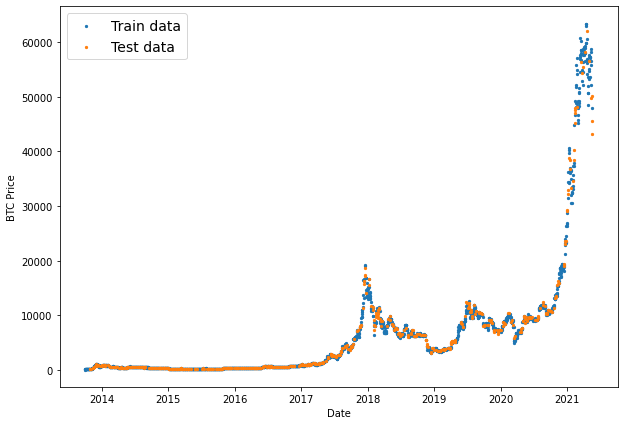

In [ ]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

Hmmm... what's wrong with this plot?

Well, let's remind ourselves of what we're trying to do.

We're trying to use the historical price of Bitcoin to predict future prices of Bitcoin.

With this in mind, our seen data (training set) is what?

Prices of Bitcoin in the past.

And our unseen data (test set) is?

Prices of Bitcoin in the future. 

Does the plot above reflect this?

No. 

Our test data is scattered all throughout the training data.

This kind of random split is okay for datasets without a time component (such as images or passages of text for classification problems) but for time series, we've got to take the time factor into account.

To fix this, we've got to split our data in a way that reflects what we're actually trying to do.

We need to split our historical Bitcoin data to have a dataset that reflects the past (train set) and a dataset that reflects the future (test set).





### Create train & test sets for time series (the right way)

Of course, there's no way we can actually access data from the future.

But we can engineer our test set to be in the future with respect to the training set.

To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)
*Demonstration of time series split. Rather than a traditionaly random train/test split, it's best to split the time series data sequentially. Meaning, the test data should be data from the future when compared to the training data.*

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

Okay, looks like our custom made splits are the same lengths as the splits we made with `train_test_split`.

But again, these are numbers on a page.

And you know how the saying goes, trust one eye more than two ears.

Let's visualize.

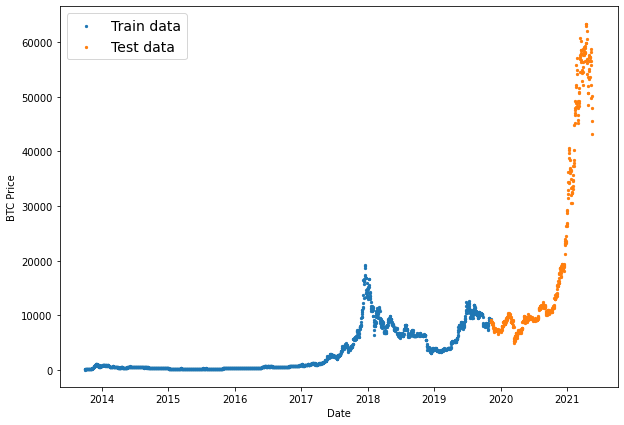

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

That looks much better!

Do you see what's happened here?

We're going to be using the training set (past) to train a model to try and predict values on the test set (future).

Because the test set is an *artificial* future, we can guage how our model might perform on *actual* future data.

> 🔑 **Note:** The amount of data you reserve for your test set not set in stone. You could have 80/20, 90/10, 95/5 splits or in some cases, you might not even have enough data to split into train and test sets (see the resource below). The point is to remember the test set is a pseudofuture and not the actual future, it is only meant to give you an indication of how the models you're building are performing. 

> 📖 **Resource:** Working with time series data can be tricky compared to other kinds of data. And there are a few pitfalls to watch out for, such as how much data to use for a test set. The article [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) talks about different things to watch out for when working with time series data, I'd recommend reading it.



### Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

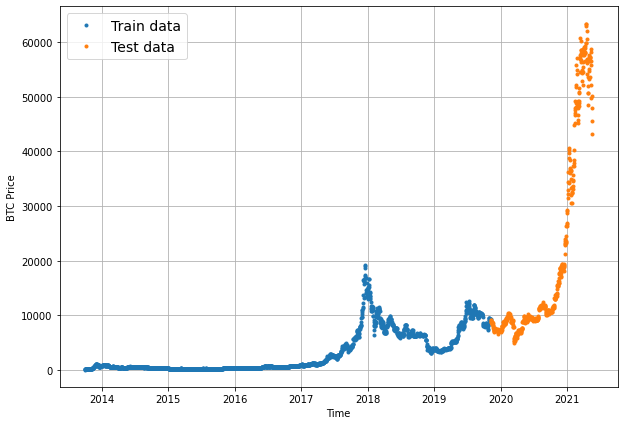

In [ ]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

Looking good!

Time for some modelling experiments.

## Modelling Experiments

We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly.

However, just because we *can* build *almost any* kind of model, doesn't mean it'll perform well/should be used in a production setting.

We'll see what this means as we build and evaluate models throughout.

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**. 
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

> 🔑 **Note:** To reiterate, as you can see, we can build many types of models for the data we're working with. But that doesn't mean that they'll perform well. Deep learning is a powerful technique but it doesn't always work. And as always, start with a simple model first and then add complexity as needed. 

## Model 0: Naïve forecast (baseline)

As usual, let's start with a baseline.

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 

In English: 
> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).

Sound simple?

Maybe not.

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

> 🔑 **Note:** For the sake of this notebook, an **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [ ]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10 

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

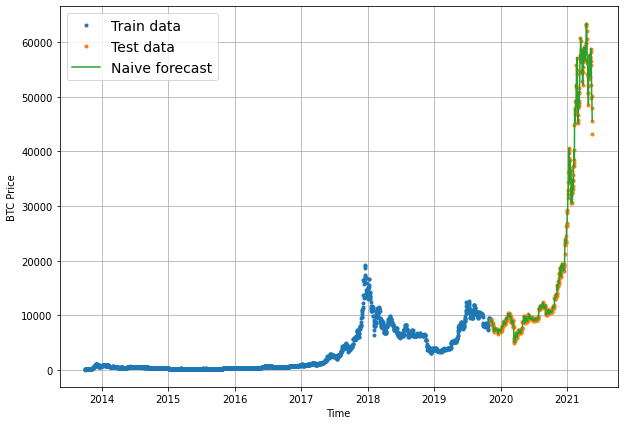

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well. 

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

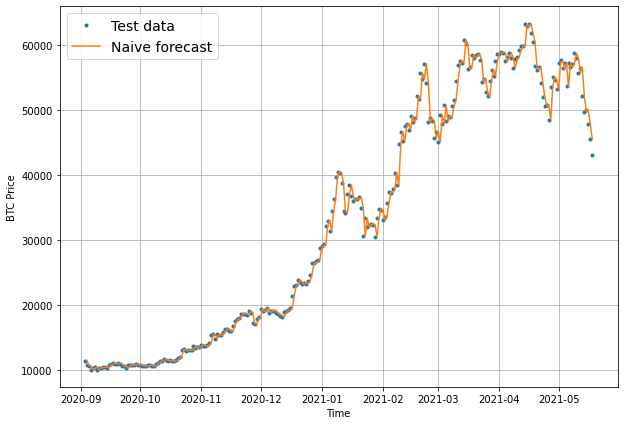

In [ ]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a time series model

Time series forecasting often involves predicting a number (in our case, the price of Bitcoin).

And what kind of problem is predicting a number?

Ten points if you said regression.

With this known, we can use regression evaluation metrics to evaluate our time series forecasts.

The main thing we will be evaluating is: **how do our model's predictions (`y_pred`) compare against the actual values (`y_true` or *ground truth values*)**? 

> 📖 **Resource:** We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html), I'd recommend reading through here for a more in-depth overview of what we're going to practice.

For all of the following metrics, **lower is better** (for example an MAE of 0 is better than an MAE 100).

### Scale-dependent errors

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) | 
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

> 🤔 **Question:** There are so many metrics... which one should I pay most attention to? It's going to depend on your problem. However, since its ease of interpretation (you can explain it in a sentence to your grandma), MAE is often a very good place to start.

Since we're going to be evaluing a lot of models, let's write a function to help us calculate evaluation metrics on their forecasts.

First we'll need TensorFlow.


In [ ]:
# Let's get TensorFlow! 
import tensorflow as tf

And since TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error), how about we create our own?

We'll take inspiration from [sktime](https://github.com/alan-turing-institute/sktime)'s (Scikit-Learn for time series) [`MeanAbsoluteScaledError`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.MeanAbsoluteScaledError.html#sktime.performance_metrics.forecasting.MeanAbsoluteScaledError) class which calculates the MASE.

In [ ]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

You'll notice the version of MASE above doesn't take in the training values like sktime's `mae_loss()`. In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Looking good! How about we test our function on the naive forecast?

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

Alright, looks like we've got some baselines to beat.

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [ ]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

Okay, looking at these two values is starting to give us an idea of how our model is performing:
* The average price of Bitcoin in the test dataset is: $20,056 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

* Each prediction in naive forecast is on average off by: $567

Is this enough to say it's a good model?

That's up your own interpretation. Personally, I'd prefer a model which was closer to the mark.

How about we try and build one?


## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

Since we've got a naïve forecast baseline to work with, it's time we start building models to try and beat it.

And because this course is focused on TensorFlow and deep learning, we're going to be using TensorFlow to build deep learning models to try and improve on our naïve forecasting results.

That being said, there are many other kinds of models you may want to look into for building baselines/performing forecasts.

Some of them may even beat our best performing models in this notebook, however, I'll leave trying them out for extra-curriculum.

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats | 
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

Surely we'd be ready to start building models by now?

We're so close! Only one more step (really two) to go.

We've got to window our time series.

Why do we window?

Windowing is a method to turn a time series dataset into **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

![windows and horizons for turning time series data into a supervised learning problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-windows-and-horizons.png)
*Example of windows and horizons for Bitcoin data. Windowing can be used to turn time series data into a supervised learning problem.*

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).

In [ ]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

Now we'll write a function to take in an array and turn it into a window and horizon.

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Oh yeah, that's what I'm talking about!

Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [ ]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

Phew! A few steps there... let's see how it goes.

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

Of course we have to visualize, visualize, visualize!

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑 **Note:** You can find a function which achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).

## Turning windows into training and test sets 

Look how good those windows look! Almost like the stain glass windows on the Sistine Chapel, well, maybe not that good but still.

Time to turn our windows into training and test splits.

We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

Look at that amazing function, lets test it.

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Notice the default split of 80% training data and 20% testing data (this split can be adjusted if needed).

How do the first 5 samples of the training windows and labels looks?

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint

We're so close to building models. So so so close.

Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.

What I mean by this is in order for a fair comparison, we want to compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

To take of this, we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

That way when evaluating our model we could restore its best performing configuration from file.

> 🔑 **Note:** Because of the size of the dataset (smaller than usual), you'll notice our modelling experiment results fluctuate quite a bit during training (hence the implementation of the `ModelCheckpoint` callback to save the best model).

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to specified filename.

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

Finally!

Time to build one of our models.

If you think we've been through a fair bit of preprocessing before getting here, you're right.

Often, preparing data for a model is one of the largest parts of any machine learning project.

And once you've got a good model in place, you'll probably notice far more improvements from manipulating the data (e.g. collecting more, improving the quality) than manipulating the model.

We're going to start by keeping it simple, `model_1` will have:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

Why these values?

I picked them out of experimentation. 

A batch size of 32 works pretty well too and we could always train for less epochs but since the model runs so fast (you'll see in a second, it's because the number of samples we have isn't massive) we might as well train for more.

> 🔑 **Note:** As always, many of the values for machine learning problems are experimental. A reminder that the values you can set yourself in a machine learning algorithm (the hidden units, the batch size, horizon size, window size) are called [**hyperparameters**](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning). And experimenting to find the best values for hyperparameters is called **hyperparameter tuning**. Where as parameters learned by a model itself (patterns in the data, formally called weights & biases) are referred to as **parameters**.

Let's import TensorFlow and build our first deep learning model for time series.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 3s 62ms/step - loss: 780.3455 - mae: 780.3455 - val_loss: 2279.6526 - val_mae: 2279.6526
Epoch 2/100
18/18 [==============================] - 1s 40ms/step - loss: 247.6756 - mae: 247.6756 - val_loss: 1005.9991 - val_mae: 1005.9991
Epoch 3/100
18/18 [==============================] - 1s 40ms/step - loss: 188.4116 - mae: 188.4116 - val_loss: 923.2862 - val_mae: 923.2862
Epoch 4/100
18/18 [==============================] - 1s 40ms/step - loss: 169.4340 - mae: 169.4340 - val_loss: 900.5872 - val_mae: 900.5872
Epoch 5/100
18/18 [==============================] - 1s 39ms/step - loss: 165.0895 - mae: 165.0895 - val_loss: 895.2238 - val_mae: 895.2238
Epoch 6/100
18/18 [==============================] - 1s 42ms/step - loss: 158.5210 - mae: 158.5210 - val_loss: 855.1982 - val_mae: 855.1982
Epoch 7/100
18/18 [==============================] - 1s 42ms/step - loss: 151.3566 - mae: 151.3566 - val_loss: 840.9168 - val_mae: 840.9168
Epoch 8/100
18/1

Because of the small size of our data (less than 3000 total samples), the model trains very fast.

Let's evaluate it.

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 585.9762 - mae: 585.9762


[585.9761962890625, 585.9761962890625]

You'll notice the model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if we load in the version of `model_1` which was saved to file using the `ModelCheckpoint` callback, we should see an improvement in results.

In [ ]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 568.9512 - mae: 568.9512


[568.951171875, 568.951171875]

Much better! Due to the fluctuating performance of the model during training, loading back in the best performing model see's a sizeable improvement in MAE.

## Making forecasts with a model (on the test dataset)

We've trained a model and evaluated the it on the test data, but the project we're working on is called BitPredict 💰📈 so how do you think we could use our model to make predictions?

Since we're going to be running more modelling experiments, let's write a function which: 
1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on) 
3. Passes the input data to the model's `predict()` method
4. Returns the predictions



In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

Nice! 

Now let's use our `make_preds()` and see how it goes.



In [ ]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.711, 8769.886, 9015.71 , 8795.517, 8723.809, 8730.11 ,
        8691.95 , 8502.054, 8460.961, 8516.547], dtype=float32)>)

> 🔑 **Note:** With these outputs, our model isn't *forecasting* yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

Excellent! Now we've got some prediction values, let's use the `evaluate_preds()` we created before to compare them to the ground truth.

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.95123,
 'mape': 2.5448983,
 'mase': 0.9994897,
 'mse': 1171744.0,
 'rmse': 1082.4713}

How did our model go? Did it beat the naïve forecast?

In [ ]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

It looks like our naïve model beats our first deep model on nearly every metric.

That goes to show the power of the naïve model and the reason for having a baseline for any machine learning project.

And of course, no evaluation would be finished without visualizing the results.

Let's use the `plot_time_series()` function to plot `model_1_preds` against the test data.

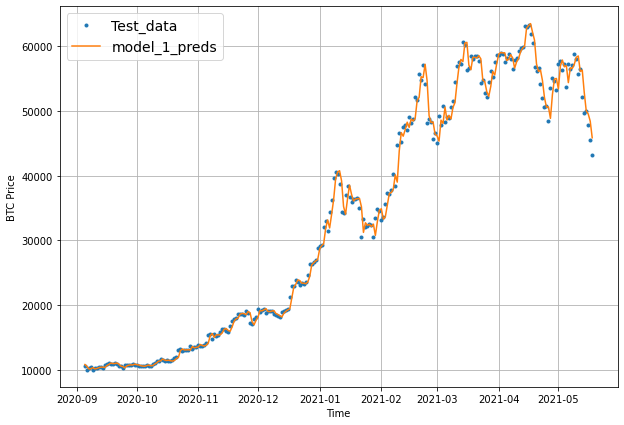

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.

With our current model setup, how do you think we'd make forecasts for the future?

Have a think about it for now, we'll cover this later on.

## Model 2: Dense (window = 30, horizon = 1)

A naïve model is currently beating our handcrafted deep learning model. 

We can't let this happen.

Let's continue our modelling experiments.

We'll keep the previous model architecture but use a window size of 30.

In other words, we'll use the previous 30 days of Bitcoin prices to try and predict the next day price.

![bitcoin prices windowed for 30 days to predict a horizon of 1 day](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-price-window-for-one-month.png)
*Example of Bitcoin prices windowed for 30 days to predict a horizon of 1.*

> 🔑 **Note:** Recall from before, the window size (how many timesteps to use to fuel a forecast) and the horizon (how many timesteps to predict into the future) are **hyperparameters**. This means you can tune them to try and find values will result in better performance.

We'll start our second modelling experiment by preparing datasets using the functions we created earlier.

In [ ]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

Data prepared!

Now let's construct `model_2`, a model with the same architecture as `model_1` as well as the same training routine.

In [ ]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

Once again, training goes nice and fast.

Let's evaluate our model's performance.

In [ ]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.9615


608.9614868164062

Hmmm... is that the best it did?

How about we try loading in the best performing `model_2` which was saved to file thanks to our `ModelCheckpoint` callback.

In [ ]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.9615


608.9614868164062

Excellent! Loading back in the best performing model see's a performance boost.

But let's not stop there, let's make some predictions with `model_2` and then evaluate them just as we did before.

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.9615,
 'mape': 2.7693386,
 'mase': 1.0644706,
 'mse': 1281438.8,
 'rmse': 1132.0065}

It looks like `model_2` performs worse than the naïve model as well as `model_1`!

Does this mean a smaller window size is better? (I'll leave this as a challenge you can experiment with)

How do the predictions look?

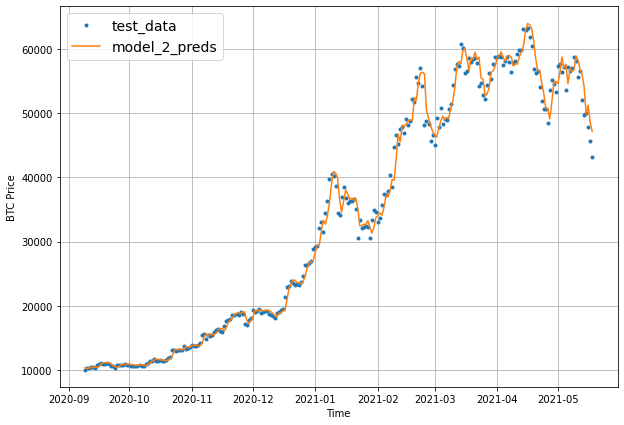

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.


In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

And we'll split the full dataset windows into training and test sets.

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

Now let's build, compile, fit and evaluate a model.

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [ ]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1321.5201


1321.5201416015625

To compare apples to apples (best performing model to best performing model), we've got to load in the best version of `model_3`. 

In [ ]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1237.5065


1237.5064697265625

In this case, the error will be higher because we're predicting 7 steps at a time. 

This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).

Let's make predictions with our model using the `make_preds()` function and evaluate them using the `evaluate_preds()` function.

In [ ]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.693 , 9048.1   , 9425.088 , 9258.258 , 9495.798 , 9558.451 ,
        9357.354 ],
       [8735.507 , 8840.304 , 9247.793 , 8885.6   , 9097.188 , 9174.329 ,
        9156.819 ],
       [8672.509 , 8782.388 , 9123.8545, 8770.37  , 9007.13  , 9003.87  ,
        9042.723 ],
       [8874.399 , 8784.737 , 9043.901 , 8943.051 , 9033.479 , 9176.488 ,
        9039.676 ],
       [8825.891 , 8777.4375, 8926.779 , 8870.178 , 9213.232 , 9268.156 ,
        8942.485 ]], dtype=float32)>

In [ ]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 513.60516 ,  355.0837  ,  327.17007 ,  358.50992 ,  420.53207 ,
         537.8537  ,  545.6606  ,  485.92307 ,  584.4969  ,  687.38153 ,
         836.22675 ,  755.1571  ,  731.4959  ,  775.33984 ,  567.95465 ,
         266.80865 ,  188.80225 ,  188.1077  ,  253.09521 ,  301.43365 ,
         151.10742 ,  196.81424 ,  191.46184 ,  231.6506  ,  143.6114  ,
         122.5904  ,  132.78844 ,  190.8116  ,  179.15967 ,  228.25955 ,
         314.4401  ,  379.09277 ,  278.3254  ,  295.34604 ,  299.38525 ,
         248.64977 ,  299.7564  ,  259.6937  ,  180.30566 ,  206.72879 ,
         374.62912 ,  144.85143 ,  142.33607 ,  131.11572 ,   93.940636,
          54.825615,   73.79423 ,  103.59996 ,  121.33385 ,  168.67201 ,
         183.90945 ,  152.25307 ,  186.57129 ,  146.91316 ,  240.42961 ,
         351.00656 ,  540.9515  ,  549.15674 ,  521.2421  ,  526.85535 ,
         453.36295 ,  257.98166 ,  277.29492 ,  301.82465 ,  455.71756 ,
         458.9599  ,  503.44427 ,  522.3119 

## Make our evaluation function work for larger horizons

You'll notice the outputs for `model_3_results` are multi-dimensional. 

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Now we've updated `evaluate_preds()` to work with multiple shapes, how does it look?

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1237.5063,
 'mape': 5.558879,
 'mase': 2.2020736,
 'mse': 5405198.0,
 'rmse': 1425.7477}

Time to visualize.

If our prediction evaluation metrics were mutli-dimensional, how do you think the predictions will look like if we plot them?

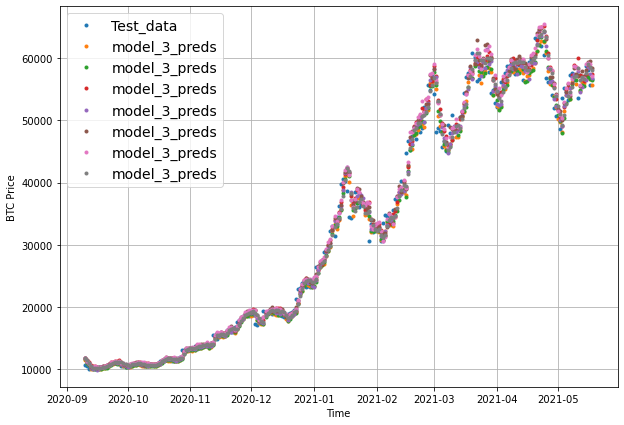

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

When we try to plot our multi-horizon predicts, we get a funky looking plot.

Again, we can fix this by aggregating our model's predictions.

> 🔑 **Note:** Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.

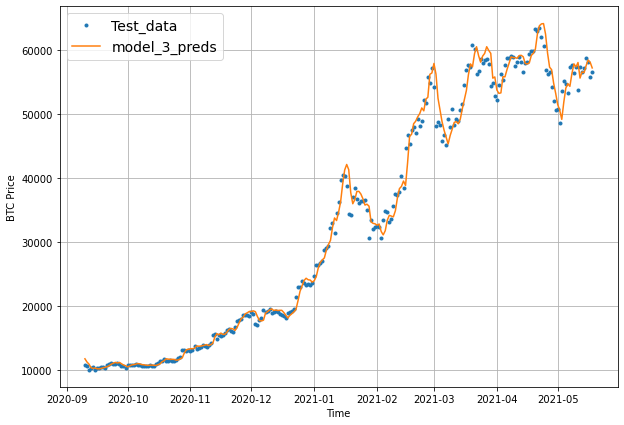

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

## Which of our models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

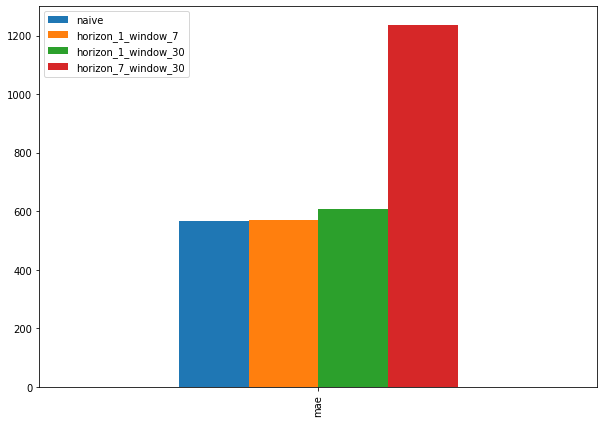

In [ ]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Woah, our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of **autocorrelation** in the data. If a time series has **autocorrelation** it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [*How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls*](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) by Vegard Flovik

## Model 4: Conv1D

Onto the next modelling experiment!

This time, we'll be using a Conv1D model. Because as we saw in the sequence modelling notebook, Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

![bitcoin prediction in seq2seq terms](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-forecast-in-seq2seq-terms.png)
*Framing Bitcoin forecasting in seq2seq (sequence to sequence) terms. Using a window size of 7 and a horizon of one results in a many to one problem. Using a window size of >1 and a horizon of >1 results in a many to many problem. The diagram comes from Andrei Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*.

Before we build a Conv1D model, let's recreate our datasets.

In [ ]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [ ]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Data windowed!

Now, since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` (by default this is 32 but we can change it) is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin 
* `input_dim = HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension. 

In [ ]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a [`tf.keras.layers.Lamdba`](https://keras.io/api/layers/core_layers/lambda/) (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

Let's try it out.

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


Looking good!

Now we've got a Lambda layer, let's build, compile, fit and evaluate a Conv1D model on our data.

> 🔑 **Note:** If you run the model below without the Lambda layer, you'll get an input shape error (one of the most common errors when building neural networks).

In [ ]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets wr

What does the Lambda layer look like in a summary?

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


The Lambda layer appears the same as any other regular layer. 

Time to evaluate the Conv1D model.

In [ ]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 570.8284


570.8284301757812

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8851.465, 8754.47 , 8983.928, 8759.672, 8703.628, 8708.294,
       8661.668, 8494.839, 8435.316, 8492.114], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 570.8284,
 'mape': 2.5593357,
 'mase': 1.0027875,
 'mse': 1176671.2,
 'rmse': 1084.7448}

## Model 5: RNN (LSTM)

As you might've guessed, we can also use a recurrent neural network to model our sequential time series data.

> 📖 **Resource:** For more on the different types of recurrent neural networks you can use for sequence problems, see the [Recurrent Neural Networks section of notebook 08](https://dev.mrdbourke.com/tensorflow-deep-learning/08_introduction_to_nlp_in_tensorflow/#recurrent-neural-networks-rnns).

Let's reuse the same data we used for the Conv1D model, except this time we'll create an [LSTM-cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) powered RNN to model our Bitcoin data. 

Once again, one of the most important steps for the LSTM model will be getting our data into the right shape.

The [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer takes a tensor with `[batch, timesteps, feature]` dimensions.

As mentioned earlier, the `batch` dimension gets taken care of for us but our data is currently only has the `feature` dimension (`WINDOW_SIZE`).

To fix this, just like we did with the `Conv1D` model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.








In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 596.6447


596.6446533203125

Now we've got the best performing LSTM model loaded in, let's make predictions with it and evaluate them.

In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8991.225, 8823.2  , 9009.359, 8847.859, 8742.254, 8788.655,
       8744.746, 8552.568, 8514.823, 8542.873], dtype=float32)>

In [ ]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 596.64465,
 'mape': 2.6838453,
 'mase': 1.0481395,
 'mse': 1273486.9,
 'rmse': 1128.4888}

Hmmm... it seems even with an LSTM-powered RNN we weren't able to beat our naïve models results.

Perhaps adding another variable will help?

> 🔑 **Note:** I'm putting this here again as a reminder that because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.


## Make a multivariate time series 

So far all of our models have barely kept up with the naïve forecast.

And so far all of them have been trained on a single variable (also called univariate time series): the historical price of Bitcoin.

If predicting the price of Bitcoin using the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help.

More information is a vague term because we could actually feed almost anything to our model(s) and they would still try to find patterns. 

For example, we could use the historical price of Bitcoin as well as anyone with the name [Daniel Bourke Tweeted](https://twitter.com/mrdbourke) on that day to predict the future price of Bitcoin.

But would this help?

Porbably not.

What would be better is if we passed our model something related to Bitcoin (again, this is quite vauge, since in an open system like a market, you could argue everything is related).

This will be different for almost every time series you work on but in our case, we could try to see if the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) adds any predictive power to our model(s).

What is the Bitcoin block reward size?

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.

Let's encode this information into our time series data and see if it helps a model's performance.

> 🔑 **Note:** Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from **univariate** (only the historical price of Bitcoin) to **multivariate** (the price of Bitcoin as well as the block reward size).

In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Alright, time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) | 

> 🔑 **Note:** Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [ ]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We're going to get the days (indexes) for different block reward values. 

This is important because if we're going to use multiple variables for our time series, they have to the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

> 🔑 **Note:** For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.

In [ ]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

Now we can add another feature to our dataset `block_reward` (this gets lower over time so it may lead to increasing prices of Bitcoin).

In [ ]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


Woohoo! We've officially added another variable to our time series data.

Let's see what it looks like.

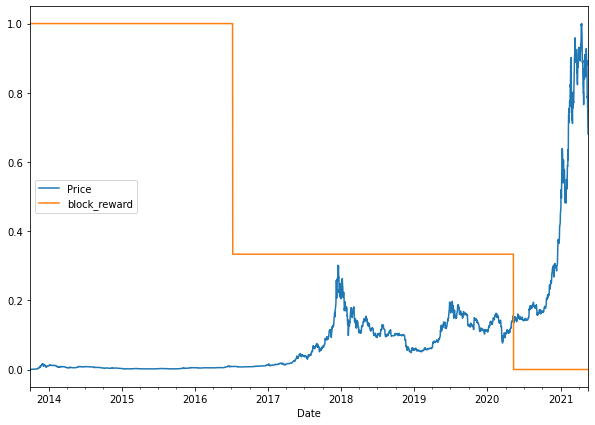

In [ ]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.

## Making a windowed dataset with pandas

Previously, we used some custom made functions to window our **univariate** time series.

However, since we've just added another variable to our dataset, these functions won't work.

Not to worry though. Since our data is in a pandas DataFrame, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.

Let's see it in action.

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


Now that we've got a windowed dataset, let's separate features (`X`) from labels (`y`).

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

```
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the `NaN` values using pandas [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

What a good looking dataset, let's split it into train and test sets using an 80/20 split just as we've done before.

In [ ]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Training and test multivariate time series datasets made! Time to build a model.

## Model 6: Dense (multivariate time series)

To keep things simple, let's the `model_1` architecture and use it to train and make predictions on our multivariate time series data.

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


Multivariate model fit!

You might've noticed that the model inferred the input shape of our data automatically (the data now has an extra feature). Often this will be the case, however, if you're running into shape issues, you can always explicitly define the input shape using `input_shape` parameter of the first layer in a model.

Time to evaluate our multivariate model.

In [ ]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 567.5873


567.5873413085938

In [ ]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8836.276, 8763.8  , 9040.486, 8741.225, 8719.326, 8765.071,
       8661.102, 8496.891, 8463.231, 8521.585], dtype=float32)>

In [ ]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.5874,
 'mape': 2.541387,
 'mase': 0.99709386,
 'mse': 1161688.4,
 'rmse': 1077.8165}

Hmmm... how do these results compare to `model_1` (same window size and horizon but without the block reward feature)?

In [ ]:
model_1_results

{'mae': 568.95123,
 'mape': 2.5448983,
 'mase': 0.9994897,
 'mse': 1171744.0,
 'rmse': 1082.4713}

It looks like the adding in the block reward may have helped our model slightly.

But there a few more things we could try.

> 📖 **Resource:** For different ideas on how to improve a neural network model (from a model perspective), refer to the [*Improving a model*](https://dev.mrdbourke.com/tensorflow-deep-learning/02_neural_network_classification_in_tensorflow/#improving-a-model) section in notebook 02.


> 🛠 **Exercise(s):** 
> 1. Try adding an extra `tf.keras.layers.Dense()` layer with 128 hidden units to `model_6`, how does this effect model performance?
> 2. Is there a better way to create this model? As in, should the `block_reward` feature be bundled in with the Bitcoin historical price feature? Perhaps you could test whether building a multi-input model (e.g. one model input for Bitcoin price history and one model input for `block_reward`)  works better? See [*Model 4: Hybrid embedding*](https://dev.mrdbourke.com/tensorflow-deep-learning/09_SkimLit_nlp_milestone_project_2/#model-4-combining-pretrained-token-embeddings-character-embeddings-hybrid-embedding-layer) section of notebook 09 for an idea on how to create a multi-input model.

Model 7: N-BEATS algorithm


In [ ]:
#Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size:int,
               theta_size:int,
               horizon: int,
               n_neurons:int,
               n_layers:int,
               **kwargs): #the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
  
    #Block contains stack of 4 fully connected layers each has ReLu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation = "relu") for _ in range(n_layers) ]
    #Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation = "linear", name = "theta")
  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x) #x is going to get continually updated as it passes through each layer in the FC stack
      theta = self.theta_layer(x)
      #Output the backcast and the forecast from theta
      backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
      return backcast, forecast

               

Lets test our NBeatsBlock class
to do this well make some dummy inputs and outputs

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size = WINDOW_SIZE,
                                       theta_size = WINDOW_SIZE + HORIZON, #BACKCAST + FORECAST
                                       horizon = HORIZON,
                                       n_neurons = 128,
                                       n_layers = 4)

In [ ]:
#Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) +1, axis = 0) #input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
#Pass dummy inputs to dummy nbeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
#These are the activationnoutputs of the theta layer (theyll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.18105811  2.9291492  -0.01894116 -1.3129209  -1.7796531   1.192435
 -1.2437686 ]
Forecast: 1.1991429328918457


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast sa possible were going to be adhearing to the performant data pipeline steps in the tf.data guide

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
#Create N-BEATS data inputs (N-BEATS works with univariate time series)
#Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods = i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Make features and labels
x = bitcoin_prices_nbeats.dropna().drop("Price", axis = 1)
y = bitcoin_prices_nbeats.dropna()["Price"]

#Make train and test sets
split_size = int(len(x) * 0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
#Time to make our dataset performant using tf.data.API
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

#Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset



(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

In [ ]:
### Setting up hyperparameters for N-BEATS algorithm

#Values from N-Beats paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON #the theta is the backcast and the forecast


INPUT_SIZE, THETA_SIZE


(7, 8)

###Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add)

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

#Subtract
subtracted = layers.subtract([tensor_1, tensor_2])
added = layers.add([tensor_1, tensor_2])

#Get outputs
print(f"input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"subtracted: {subtracted.numpy()}")
print(f"added: {added.numpy()}")

input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
subtracted: [10 10 10 10 10 10 10 10 10 10]
added: [10 12 14 16 18 20 22 24 26 28]


##Building, compilling and fitting the N_BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (thisll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (well be using the keras functional api)
3. Make the initial backcast and forecast for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but well use MAE to keep it in line with our other models and Adam optimizer with default settings per the N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs, well use callbacks:
  * Early stopping - stop training early if model stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning rate to reduce the amount it updates its weights each time(take smaller steps towards best performance)


In [ ]:
%%time

tf.random.set_seed(42)
#1. Setup instance of NBeatsBlock 
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size = THETA_SIZE,
                                 horizon = HORIZON,
                                 n_neurons = N_NEURONS,
                                 n_layers = N_LAYERS,
                                 name = "InitialBlock")
#2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name = "stack_input")

#3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

#4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS -1)): #First stack is already created in 3 (stack -1)
  #5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
    input_size = INPUT_SIZE,
    theta_size = THETA_SIZE,
    horizon = HORIZON,
    n_neurons = N_NEURONS,
    n_layers = N_LAYERS,
    name = f"NBeatsBlock_{i}"
  )(residuals) #Pass in residuals as input
  #6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name = f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name = f"add_{i}")

#7. put the stack model together
model_7 = tf.keras.Model(inputs = stack_input, outputs = forecast, name = "model_7_NBEATS") #We want our model to output global forecast

#8. Compile model with MAE loss
model_7.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam())

#9 Fit the model with early stopping and reduce lr on plateau callbacks
model_7.fit(train_dataset,
            epochs = N_EPOCHS,
            validation_data = test_dataset,
            verbose = 0,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                          patience = 200,
                                                          restore_best_weights = True),
                         tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                              patience = 100,
                                                              verbose = 1)])




Epoch 00629: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00729: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 24s, sys: 3.47 s, total: 1min 27s
Wall time: 1min 30s


In [ ]:
#Evaluate N-Beats model on test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 27ms/step - loss: 570.4371


570.4370727539062

In [ ]:
#make predictions with N-BEATS
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8869.951, 8806.996, 9018.749, 8768.932, 8752.977, 8737.834,
       8668.264, 8535.197, 8466.659, 8521.4  ], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_7_preds)
model_7_results

{'mae': 570.4371,
 'mape': 2.5606287,
 'mase': 1.0021,
 'mse': 1167241.5,
 'rmse': 1080.3895}

### Plotting the N-Beats architectrue weve created

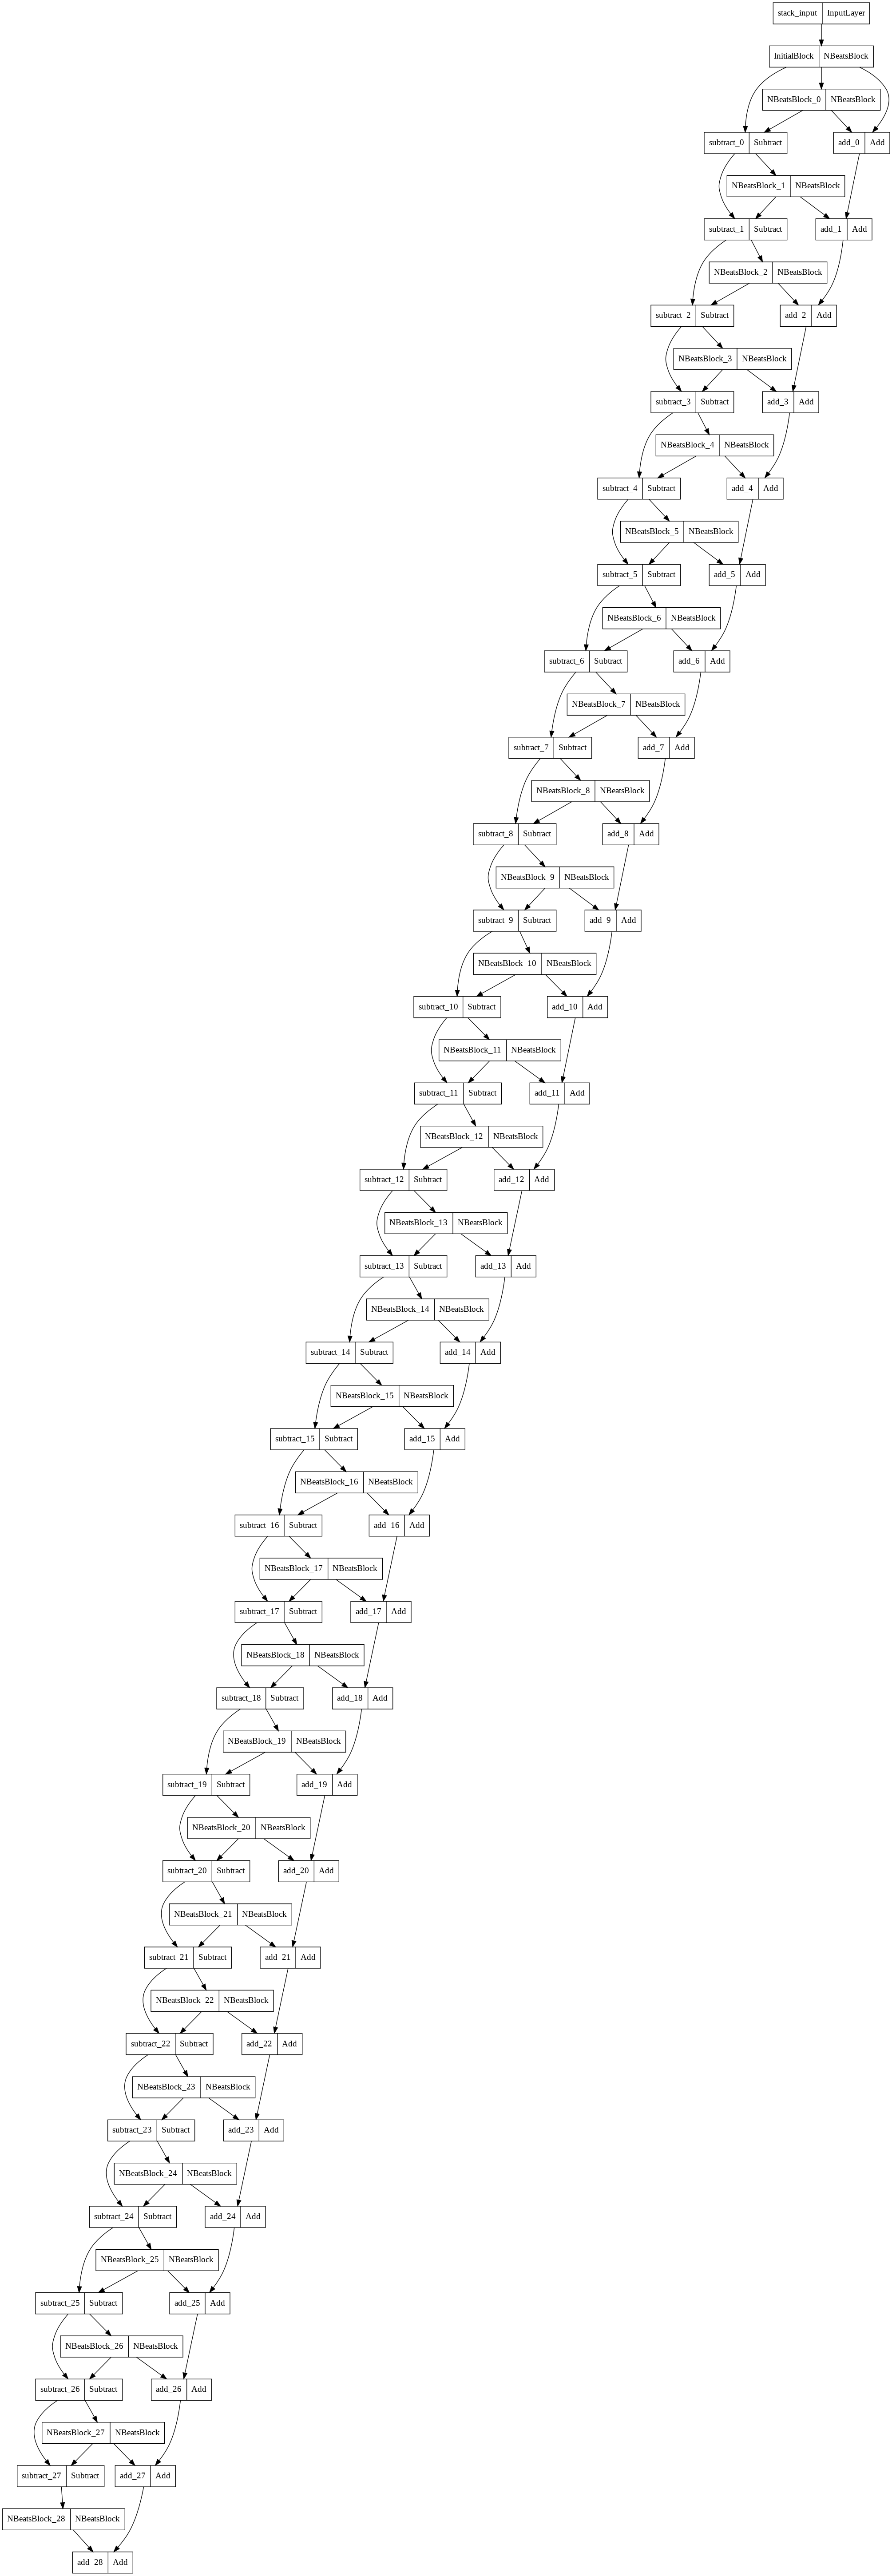

In [ ]:
# Plot the N-BEATS model and inspect the archetecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

##Model 8 : creating an ensemble (Stacking different models together)

An ensemble leveragers the wisdom of the crowd efect

###Construct and fitting an ensemble of models (using different loss functions)


In [ ]:
def get_ensemble_models(horizon = HORIZON,
                        train_data = train_dataset,
                        test_data = test_dataset,
                        num_iter = 10,
                        num_epochs = 1000,
                        loss_fns = ["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss
  for ex, if num_ier = 10 a list of 30 trained models will be returned:
    10 * len(["mae", "mse", "mape"])
  """
  #Making empty list for trained ensemble models
  ensemble_models = []

  #Create num_iter number of models per loss function
  for i in range(num_iter): #loop through the number of iterations
    #Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optmizing model by reducing loss function: {loss_function} for {num_epochs} epochs, model number {i}")

      #construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
                                   #initialize dense layers with normal distribution for estimating prediction intervals later on
                                   layers.Dense(128, kernel_initializer = "he_normal", activation = "relu"),
                                   layers.Dense(128, kernel_initializer = "he_normal",  activation = "relu"),
                                   layers.Dense(HORIZON)
      ])

      #Compile simple model with current loss function
      model.compile(loss = loss_function,
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics = ["mae", "mse"])
      #Fit the current model
      model.fit(train_data,
                epochs = num_epochs,
                verbose =0,
                validation_data = test_data,
                callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                              patience = 200,
                                                              restore_best_weights = True),
                             tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                                  patience = 100,
                                                                  verbose = 1)])
      #Append fitted model to list of ensemble models
      ensemble_models.append(model)
  return ensemble_models


In [ ]:
%%time
#Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter = 5,
                                      num_epochs = 1000)

Optmizing model by reducing loss function: mae for 1000 epochs, model number 0

Epoch 00488: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00588: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optmizing model by reducing loss function: mse for 1000 epochs, model number 0

Epoch 00759: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00859: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optmizing model by reducing loss function: mape for 1000 epochs, model number 0

Epoch 00167: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00730: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00830: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optmizing model by reducing loss function: mae for 1000 epochs, model number 1

Epoch 00876: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optmizing model by reducing

###Make predictions with ensemble model

In [ ]:
#Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
#Create list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models= ensemble_models,
                                     data = test_dataset)
ensemble_preds

CPU times: user 837 ms, sys: 44.8 ms, total: 881 ms
Wall time: 858 ms


In [ ]:
ensemble_median = np.median(ensemble_preds, axis= 0)
ensemble_median

array([ 8783.327 ,  8787.875 ,  9063.089 ,  8722.17  ,  8748.825 ,
        8720.433 ,  8669.114 ,  8493.648 ,  8457.1455,  8527.955 ,
        8205.6045,  8116.115 ,  8061.135 ,  7631.1685,  7307.661 ,
        7329.0176,  7087.1035,  7209.3965,  7137.6636,  7513.7075,
        7409.463 ,  7723.2417,  7584.817 ,  7369.0107,  7332.5234,
        7318.286 ,  7198.787 ,  7382.428 ,  7515.5195,  7534.0024,
        7559.878 ,  7327.7837,  7227.623 ,  7184.5635,  7182.0605,
        7230.1064,  7071.913 ,  7098.955 ,  6874.682 ,  6585.796 ,
        7403.376 ,  7152.5264,  7126.053 ,  7298.4844,  7274.4604,
        7180.048 ,  7221.132 ,  7209.643 ,  7178.283 ,  7219.59  ,
        7310.33  ,  7394.3438,  7249.547 ,  7167.878 ,  7167.958 ,
        6953.5923,  7287.9336,  7343.58  ,  7352.922 ,  7737.7812,
        8067.2896,  8120.789 ,  7836.6523,  8080.677 ,  8101.1997,
        8168.1016,  8119.3457,  8750.852 ,  8912.714 ,  8746.191 ,
        8945.668 ,  8962.965 ,  8667.99  ,  8647.0625,  8700.5

In [ ]:
#Evaluate ensemble model predictions
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 566.14795,
 'mape': 2.5429404,
 'mase': 0.9945651,
 'mse': 1147523.6,
 'rmse': 1071.2253}

our ensemble preds come out in multiple dimensions but to combine into point predictions we can leverage the mean of all the predictions


###Plotting the prediction intervals (uncertainty estimates) of our ensemble

so far weve been making point predictions with our models.

e.g. horizon = 1, our model predicts tomrrows price of bitcoin will be $50,0000USD

Wouldnt it be helpful if we knew a range of where that prediction came from

instead of $50,0000USD on the dot, how about 48,000 - 52,000USD?

One way yo get the 95% confidence prediction intervals for a deep learning model is the bootstrap model:
1. Take the predictions from  a number of randomly initialized models( weve got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is normal) 95% of predictions fall within 1.96 standard deviations of the mean
4. To get the prediction upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions

In [ ]:
#Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): #1. take the predictions from a number of randomly initialized models

  #2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis = 0)

  #3. Multiply the standard by 1.96 
  interval = 1.96 * std 

  #4. get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis = 0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper


In [ ]:
#Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds = ensemble_preds)


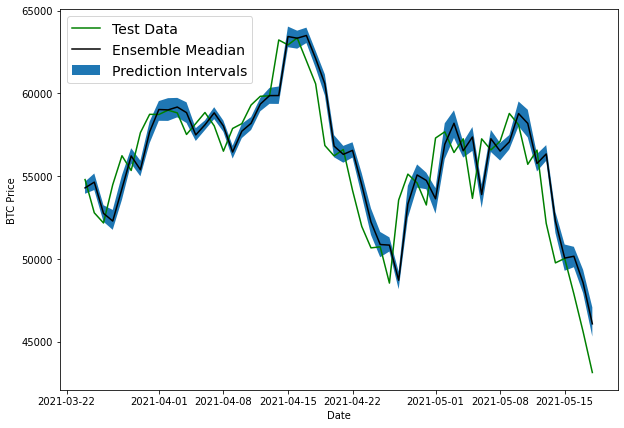

In [ ]:
#Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis = 0)

#PLot the median of our ensemble preds along with the prediction intervals(where the predictions fall between)
offset = 500
plt.figure(figsize=(10,7))
plt.plot(x_test.index[offset:], y_test[offset:], "g", label = "Test Data")
plt.plot(x_test.index[offset:], ensemble_median[offset:], "k-", label = "Ensemble Meadian")
plt.xlabel("Date")
plt.ylabel("BTC Price")
#Plot the upper and lower bounds using fill_between
plt.fill_between(x_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label = "Prediction Intervals")
plt.legend(loc = "upper left", fontsize = 14)

The prediction intervals are estimates themselves. And they have been created with the assumption that our models data is from a normal distribution

Two types of uncertainty (cocnut and subway)

uncertainty estimates in machine learning seek out to qualitativley and quantitaively answer the questions:

1. Whatcan my model know?(with perfect data whats possible for a model to learn)
2. What doesnt my model know? (What can a model never predict or would it be helpful if a model oculd tell you that when its making a prediction, it doesnt actually know if its right or not?)

Two major types of uncertainty in machine learning:

* Aleatoric uncertainty - this type of uncertainty cannot be reduced and it is often referred to as data uncertainty or subway uncertainty
* Epistemic uncertainty - this type of uncertainty can be reduced it is also referred to as model or coconut uncertainty

##Model 9: Train a model on the full historical data to make prediction into the future

so far all of our models have predicted on the test dataset, however this is only a pseudofuture

lets now build a model which is capable of predicting into the future

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [ ]:
#Train model on entire data to make predictions for the next day
x_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis = 1).to_numpy()
    #Ger labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()
len(x_all), len(y_all)


(2780, 2780)

In [ ]:
#Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(x_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

#Batch and prefetch for optimial performance

BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
tf.random.set_seed(42)
#Create model 
model_9 = tf.keras.Sequential([
                              layers.Dense(128, activation = "relu"),
                              layers.Dense(128, activation = "relu"),
                              layers.Dense(HORIZON)
], name ="model_9_future_model")

#Compile
model_9.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.Adam())
#Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs = 100,
            verbose = 0)

### Make predictions into future

In [ ]:
# How many timesteps to predict into the future 
INTO_FUTURE = 14
 

To make predict1. 
1. takes as input:
  * a list of values (Bitcoin historical data)
  * a trained model (Such as model_9)
  * a window into the future to predict (our INTO_FUTURE valriable)
  * the window size a model was trained on (WINDOW_SIZE) - the model can only predict on the same kind of data it was trained on 
2. Creates an empty list for future forecasts this will be returned at the end, when its full of predictions and extracts the last WINDOW_SIZE values from the input values
3. Loop INTO_FUTURE times making a prediction on WINDOW_SIZE sequences which update to remove the first value and append the latest prediction


In [ ]:
#1. create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size = WINDOW_SIZE) -> list:
  """
  Make future forecasts into future steps after values ends

  Returns future forecasts as a list of floats
  """
  #2. Create an empty list for future forecasts/prepaer data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  #3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(INTO_FUTURE):
    #Predict on the last window then append it again and agani (our model which eventuallystart to make forecasts on its opn forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis = 0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    #Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    #Update last window with new pred and get window size most recent preds (Model was trained on WINDOW_SIZE windows
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:] #Add our future pred at the end of the last window and index on it to get the most recent window size values
  return future_forecast

In [ ]:
#Make forecast into the future
future_forecast = make_future_forecasts(values = y_all,
                                        model = model_9,
                                        into_future = INTO_FUTURE,
                                        window_size = WINDOW_SIZE)

Predicting on:
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.46484375

Predicting on:
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.46484375] -> Prediction: 50985.9453125

Predicting on:
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.46484375 50985.9453125 ] -> Prediction: 48522.96484375

Predicting on:
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.46484375 50985.9453125  48522.96484375] -> Prediction: 48137.203125

Predicting on:
 [47885.62525472 45604.61575361 43144.47129086 55764.46484375
 50985.9453125  48522.96484375 48137.203125  ] -> Prediction: 47880.63671875

Predicting on:
 [45604.61575361 43144.47129086 55764.46484375 50985.9453125
 48522.96484375 48137.203125   47880.63671875] -> Prediction: 46879.71875

Predicting on:
 [43144.47129086 55764.46484375 50985.9453125  48522.96484375


###Plot future forecasts

In [ ]:
def get_future_dates(start_date, into_future, offset =1):
  """
  Returns array of datetime values ranging from start_date to start_date + into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") #Specify start date and D stands for day
  end_date = start_date + np.timedelta64(into_future, "D")#Specify end date
  return np.arange(start_date, end_date, dtype = "datetime64[D]") #Return a date range between start and end date
  

In [ ]:
#Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
type(last_timestep)

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
#Get next two weeks of timesetps
next_time_steps = get_future_dates(start_date = last_timestep,
                                   into_future = INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
#Insert last timestep/final price into next time steps and future forecasts so the plot doesnt look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0 , btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55764.465, 50985.945, 48522.965, 48137.203, 47880.637,
        46879.72 , 48227.6  , 53963.69 , 49685.56 , 47596.176, 48114.43 ,
        48808.008, 48623.855, 50178.723], dtype=float32))

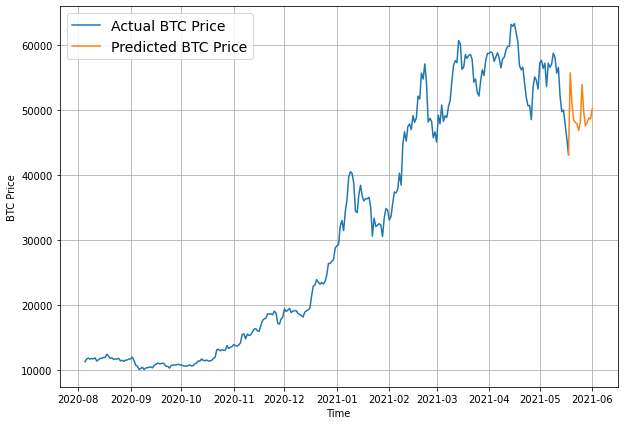

In [ ]:
#Plot future prices prediction of Bitcoin
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, btc_price, start = 2500, format = "-", label = "Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format = "-", label = "Predicted BTC Price")

##Model 10: Why forecasting is BS (the turkey problem)


In [ ]:
 #Lets introduce a turkey problem to our BTC data (price of BTC falls 100x in one day)
 btc_price_turkey = btc_price.copy()
 btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
#Manufacture an extra price on the end (to showcase our turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [ ]:
#Get timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]


array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

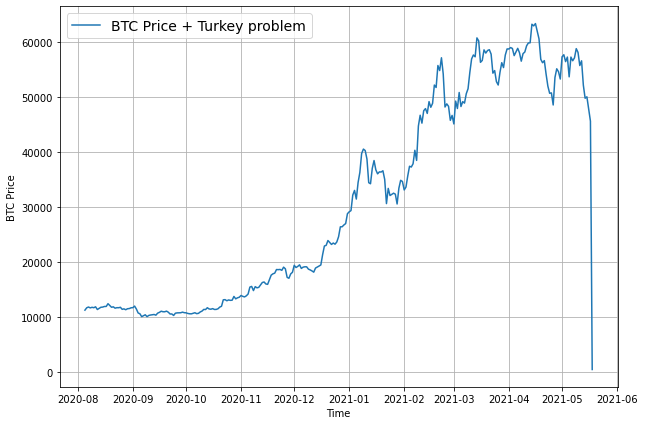

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps = btc_timesteps_turkey,
                 values = btc_price_turkey,
                 format = "-",
                 label = "BTC Price + Turkey problem",
                 start = 2500)

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
#Create train and test sets for the turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size = WINDOW_SIZE, horizon = HORIZON)
x_train, x_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)

##Build a turkey model (model to perdict on turkey)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_Turkey_model"
turkey_model.compile(loss = "mae",
                     optimizer = tf.keras.optimizers.Adam())
turkey_model.fit(x_train, y_train,
                 epochs = 100,
                 verbose = 0,
                 batch_size = 128,
                 validation_data = (x_test, y_test),
                 callbacks = [create_model_checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_Turkey_model/assets


In [ ]:
#Evaluate model on test data
turkey_model.evaluate(x_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 719.4105


719.4105224609375

In [ ]:
#Load best performing turkey model andevaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/model_10_Turkey_model")
turkey_model.evaluate(x_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 640.1680


640.16796875

In [ ]:
# make prediction with turkey model
turkey_preds = make_preds(turkey_model, x_test)
turkey_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8841.26 , 8774.641, 9015.577, 8770.346, 8745.853, 8723.038,
       8660.737, 8532.631, 8443.05 , 8517.348], dtype=float32)>

In [ ]:
#Evaluate turkey preds
turkey_results = evaluate_preds(y_true = y_test,
                                y_pred = turkey_preds)
turkey_results

{'mae': 17126.209,
 'mape': 121.31486,
 'mase': 26.502863,
 'mse': 614238300.0,
 'rmse': 23709.021}

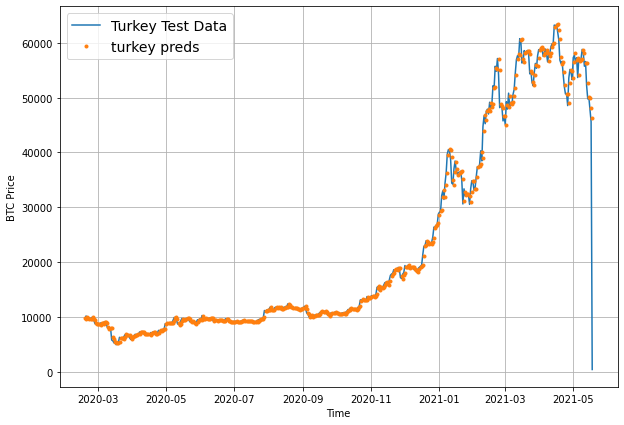

In [ ]:
plt.figure(figsize=(10,7))
offset = 100
plot_time_series(timesteps = btc_timesteps_turkey[-len(x_test):],
                 values = btc_price_turkey[-len(y_test):],
                 format = "-",
                 label = "Turkey Test Data", start = offset)
plot_time_series(timesteps = btc_timesteps_turkey[-len(x_test):],
                 values = turkey_preds,
                 label = "turkey preds",
                 start = offset);

 ##Compare models

In [ ]:
#Compare different model results (w = window, h = horizon)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)                              

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,568.951233,1.171744e+06,1082.471313,2.544898,0.999490
model_2_dense_w30_h1,608.961487,1.281439e+06,1132.006470,2.769339,1.064471
model_3_dense_w30_h7,1237.506348,5.405198e+06,1425.747681,5.558879,2.202074
model_4_CONV1D,570.828430,1.176671e+06,1084.744751,2.559336,1.002787
model_5_LSTM,596.644653,1.273487e+06,1128.488770,2.683845,1.048139
model_6_multivariate,567.587402,1.161688e+06,1077.816528,2.541387,0.997094
model_7_NBEATS,570.437073,1.167242e+06,1080.389526,2.560629,1.002100
model_8_ensemble,566.147949,1.147524e+06,1071.225342,2.542940,0.994565
model_10_turkey,17126.208984,6.142383e+08,23709.021484,121.314857,26.502863


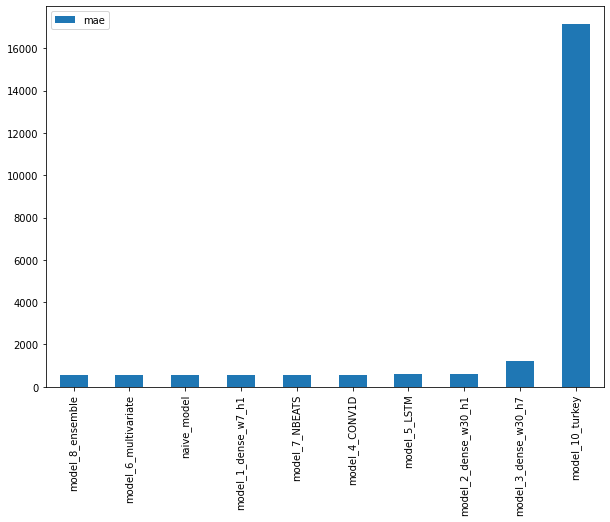

In [ ]:
#Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by = "mae").plot(figsize=(10,7), kind = "bar");